<h2> Lab 5

In [6]:
# Basic Packages
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import time
import joblib #for parallelization
# Scikit-learn
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Scikit-optimise
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
# For grid tuning
from itertools import product

<h3> Exercise Set 1

Hyperparameters to be tuned
- num Layers
- nodes / layer
- learning rate
- batch size
- dropout rate
- num epochs

Evol search, random search, manual testing, bayesian optimization, grid search

In [ ]:
'''
We need to optimize the following hyperparameters:
> num_layers, nodes_per_layer, learning_rate, batch_size, dropout_rate, num_epochs = []


Perform some manual testing to find limits of an acceptable runtime for the very largest cases 
> while(max_hyperparameter_values == unknown)
    > large_guesses = [large_num_layers, large_nodes_per_layer, -, large_batch_size, -, large_num_epochs]
    > manual_testing(run_FNN(large_guesses))
    > update(max_hyperparameter_values)

For two of the hyperparameters, dropout_rate and learning_rate, we guess some standard values for their max size
> max_dropout_rate = 0.5
> max_learning_rate = 1e-3

To find minimum hyperparameter values, we can use some random guesses loosely based on how many inputs we have.
Below is some example values 
> min_num_layers = 3
> min_nodes_per_layer = max(num_FNN_inputs, 3)
> min_learning_rate = 1e-4
> min_batch_size = 1
> min_dropout_rate = 0.01
> min_num_epochs = 10

We now know the range of hyperparameter values to sweep over with our optimization. These max values only
are constrained by runtime, so this tells us nothing about performance of our FNN.
> range_hyperparameters = [min_num_layers, max_num_layers], [min_nodes_per_layer, max_nodes_per_layer], ...

Note that at this step we should take note that some values are discrete and some are continuous. Our genetic algorithm 
should be able to handle either.

For the actual hyperparameter tuning, we'll use a genetic algorithm since they're easy to parallelize and understand. 
We can setup a cost function based off the performance of our FNN.
> def cost(FNN)
    > return R^2 of FNN from testing values

> def run_multithreading():
    > for i <= num_threads
        > random_guess_i = some_values_in(range_hyperparameters)
        > thread_i = thread_setup(target=cost(), parameters = FNN(random_guess))
        > thread_i.start()
    > join_threads()
    return costs

> if name == '__main__':
    > num_threads = hopefully_a_bunch
    > hyperparameter_suite = random_values_in(range_hyperparameters)
    > run_multithreading()
    > for i <= num_generations
        > kill_bad_guesses(hyperparameter_suite)
        > mutate_good_guesses(hyperparameter_suite)
        > run_multithreading((hyperparameter_suite)
'''

<h3> Exercise Set 2

In [7]:
# Exercise Set 2 (a)
learning_rate = [1e-4, 5e-4, 7.5e-4, 1e-3]
num_layers = [3, 4, 5, 6]
num_nodes = [50, 100, 150, 200]

In [20]:
# Exercise Set 2 (b)
dim_learning_rate = Real(low=1e-4, high=1e-3, name='learning_rate')
dim_num_layers = Integer(low=3, high=8, name='num_layers')                  
dim_num_nodes = Categorical(categories=(25, 50, 100, 150, 200, 250, 300), \
                            name='num_nodes')

dimensions = [dim_learning_rate, dim_num_layers, dim_num_nodes]

init_guess = [5e-4, 4, 100]

In [9]:
# Exercise Set 2 (c)
learning_rate_random = np.random.uniform(1e-4, 1e-3, size=4)
num_layers_random = np.random.randint(3, 9, size=4)     # rand over [3,8]
num_nodes_random = np.random.choice([25, 50, 100, 150, 200, 250, 300], size=4)


In [10]:
# Exercise Set 2 (d)
#-----------------------
# Data preprocessing
#-----------------------

#load the x,y data and convert to numpy array
xurl='https://raw.githubusercontent.com/aims-umich/ners590data/main/crx.csv'
yurl='https://raw.githubusercontent.com/aims-umich/ners590data/main/powery.csv'
xdata=pd.read_csv(xurl).values
ydata=pd.read_csv(yurl).values

# split into training/testing sets
xtrain, xtest, ytrain, ytest=train_test_split(xdata, ydata, test_size=0.2, random_state=42)

#create min-max scaled data
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()
Xtrain=xscaler.fit_transform(xtrain)
Xtest=xscaler.transform(xtest)
Ytrain=yscaler.fit_transform(ytrain)
Ytest=yscaler.transform(ytest)

In [11]:
# Exercise Set 2 (e)
def fitness(args):
    lr, nl, nn = args
    n_nodes = np.full(nl, nn)
    model = Sequential()
    model.add(Input(shape=(Xtrain.shape[1],)))
    model.add(Dense(n_nodes[0], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    for i in range(1, nl):
        model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))
    model.add(Dense(Ytrain.shape[1], kernel_initializer='normal',activation='linear'))
    
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr), metrics=['mean_absolute_error'])

    model.fit(Xtrain, Ytrain, epochs=10, batch_size=8, validation_split = 0.15, verbose=False)
    Ynn=model.predict(Xtest)
    return r2_score(Ytest,Ynn)


<h3> Exercise Set 3

In [12]:
# Exercise Set 3 (a)
configs = list(product(learning_rate, num_layers, num_nodes))
print(len(configs))

64


In [13]:
# Exercise Set 3 (b)
t0=time.time()
r2_list = []
for item in configs:
    r2=fitness(item)
    r2_list.append(r2)
print('Grid Tuning in series took {}s to complete'.format(round(time.time()-t0)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━

In [14]:
# Exercise Set 3 (c)
grid_res = pd.DataFrame(configs, columns = ['learning_rate', 'num_layers', \
                                              'num_nodes'])
grid_res['R2'] = np.array(r2_list)
grid_res = grid_res.sort_values(['R2'], axis='index', ascending=False)
print('Best Hyperparameters:')
print(grid_res.head(1))



Best Hyperparameters:
    learning_rate  num_layers  num_nodes        R2
35        0.00075           3        200  0.976786


In [16]:
# Exercise Set 3 (d)
configs_random = list(product(learning_rate_random, num_layers_random, num_nodes_random))
print(len(configs_random))

t0=time.time()
r2_list_random = []
for item in configs_random:
    r2=fitness(item)
    r2_list_random.append(r2)
print('Random Tuning in series took {}s to complete'.format(round(time.time()-t0)))

random_res = pd.DataFrame(configs_random, columns = ['learning_rate', 'num_layers', \
                                              'num_nodes'])
random_res['R2'] = np.array(r2_list_random)
random_res = random_res.sort_values(['R2'], axis='index', ascending=False)
print('Best Hyperparameters:')
print(random_res.head(1))


64
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━

<h3> Exercise Set 4

In [1]:
# Exercise Set 4 (a)
t0 = time.time()
ncores = 4

if __name__ == "__main__":
    core_list=[]
    for item in (configs):
        core_list.append(item)
    p = multiprocessing.Pool(ncores)
    results = p.map(fitness, core_list)
    p.close()
    p.join()

print('Grid Tuning in parallel with Pool took {}s to complete'.format(round(time.time()-t0)))

I couldn't get this to run in a python notebook, but in the .py file this step took 72 seconds to complete.

In [ ]:
# Exercise Set 4 (b)
t0 = time.time()
ncores = 8

if __name__ == "__main__":
    core_list=[]
    for item in (configs_random):
        core_list.append(item)
    p = multiprocessing.Pool(ncores)
    results = p.map(fitness, core_list)
    p.close()
    p.join()

print('Random Tuning in parallel with Pool took {}s to complete'.format(round(time.time()-t0)))

I couldn't get this to run in a python notebook, but in the .py file this step took 50 seconds to complete.

<h3> Exercise Set 5

In [26]:
# Exercise Set 5 (a)
def gp_fitness(args):
    lr, nl, nn = args
    n_nodes = np.full(nl, nn)
    model = Sequential()
    model.add(Input(shape=(Xtrain.shape[1],)))
    model.add(Dense(n_nodes[0], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    for i in range(1, nl):
        model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))
    model.add(Dense(Ytrain.shape[1], kernel_initializer='normal',activation='linear'))
    
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr), metrics=['mean_absolute_error'])

    model.fit(Xtrain, Ytrain, epochs=10, batch_size=8, validation_split = 0.15, verbose=False)
    Ynn=model.predict(Xtest)
    return -1 * r2_score(Ytest,Ynn)

In [27]:
# Exercise Set 5 (b)
search_results = gp_minimize(func=gp_fitness, acq_func='EI', \
                             dimensions=dimensions, \
                             n_calls=25, x0=init_guess)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.0007743694467549639, 5, 300]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.0007513219642663433, 6, 150]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.0006828697235755387, 7, 150]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.000837978459205258, 7, 200]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.00032849005034633585, 6, 150]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.0009078568115601771, 6, 50]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.00031814956043773696, 4, 200]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/home/abedel/miniconda3/envs/ners590/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 3, 300] before, using random point [0.0009207425499710602, 6, 200]
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


    learning_rate  num_layers  num_nodes        R2
11          0.001           3        300  0.981325


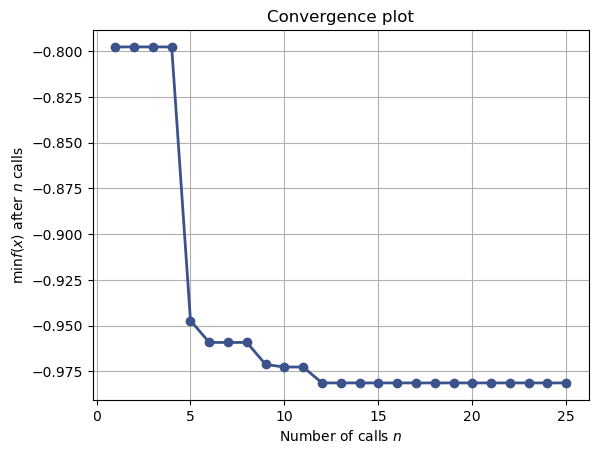

In [28]:
# plot optimization result
plot_convergence(search_results)
# Rank the search results in pandas
bayesres = pd.DataFrame(search_results.x_iters,
columns = ['learning_rate', 'num_layers', 'num_nodes'])
bayesres['R2'] = -search_results.func_vals
bayesres = bayesres.sort_values(['R2'], axis='index', ascending=False)
print(bayesres.head(1))
